# Load Data files and Import Python Libraries

In [1]:
import numpy as np

import pandas as pd

import os

from sklearn.feature_selection import RFE

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression

#import MatPlotLib
import matplotlib as mpl 

#Import PyPlot in MatPlotLib
import matplotlib.pyplot as plt 

#Import SciKitLearn decomposition PCA library
from sklearn.decomposition import PCA

#Import SciKitLearn dataset 
from sklearn import datasets as ds

#Allows for meterics to be found after Logistic Regression
from sklearn import metrics as mt

#Create KFolds for CV_Object
from sklearn.model_selection import StratifiedKFold

#Creates Standard Scaler Variables
from sklearn.preprocessing import StandardScaler

#Seaborn 
import seaborn as sb

directory = '//users/cmirwin/desktop/Capstone/'

if not os.path.exists(directory):
    os.makedirs(directory)

#Import Team Info
dfGameData = pd.read_csv(directory + 'GameData.csv', sep='|')

dfGameData.head()

/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,GameID,HomeTeam,AwayTeam,GameWinner,GameLoser,ScoreHome,ScoreAway,HomeFirstDowns,HomePassingYards,HomePenaltyCnt,...,WindChill,HeatIndex,HomePassYardsPerAttempt,HomePassingCompPct,AwayPassYardsPerAttempt,AwayPassingCompPct,HomeRushYardsPerAttempt,AwayRushYardsPerAttempt,HomeTeamWin,Degrees
0,1,PIT,TEN,PIT,TEN,13,10,19,321,6,...,NaN,NaN,9.727273,0.767442,10.636364,0.628571,1.565217,3.440000,1,67.5
1,2,ATL,MIA,ATL,MIA,19,7,19,213,4,...,NaN,NaN,9.681818,0.611111,7.761905,0.700000,2.518519,4.363636,1,90.0
2,3,BAL,KC,BAL,KC,38,24,32,303,8,...,NaN,NaN,11.653846,0.604651,9.937500,0.666667,4.829268,1.705882,1,0.0
3,4,CAR,PHI,PHI,CAR,10,38,14,83,5,...,NaN,81.0,5.928571,0.411765,4.823529,0.586207,2.866667,5.781250,0,22.5
4,5,CIN,DEN,DEN,CIN,7,12,16,221,4,...,NaN,NaN,10.523810,0.636364,13.352941,0.607143,3.185185,3.750000,0,67.5


 # Create Dummy Variables for Dataset

In [2]:
#Create new DataFrame for PCA
gameDataPCA = dfGameData

dummiesColumnToCreate = ['WindDir', 'Condition','TimeOfDay']

#Create Dummy Variables
for column in dummiesColumnToCreate:
    dummies = pd.get_dummies(gameDataPCA[str(column)]).rename(columns=lambda x: str(column) + '_' + str(x))
    #Join to Dataframe for Model
    gameDataPCA = pd.concat([gameDataPCA, dummies], axis=1)

gameDataPCA.head()
    
#Get columns that are only numeric in nature. 
columnsToDrop = ['HomeTeam', 'AwayTeam', 'GameWinner','GameLoser', 'WindDir', 'Condition','TimeOfDay', 'Date'
                 , 'HomePossTime', 'AwayPossTime']

#Drop Variables
gameDataPCA.drop(columnsToDrop, inplace=True, axis=1)

#Fill in Missing Values with 0
gameDataPCA.fillna(0, inplace=True)



# Feature Selection
## Recursive Feature Elimination

In [3]:
gameDataVariables = gameDataPCA.columns.values.tolist()
y = gameDataPCA['HomeTeamWin']
X=[i for i in gameDataVariables if i not in y]

logreg = LogisticRegression()
rfe = RFE(logreg, 18)
rfe = rfe.fit(gameDataPCA[X], y )

dfColumns = pd.DataFrame(X)

dfRankings = pd.DataFrame(rfe.ranking_)

dfColumnResults =  pd.concat([dfRankings, dfColumns], axis=1, join_axes=[dfRankings.index])

dfColumnResults.columns = ['Value', 'ColumnName']

dfColumnsForModel = dfColumnResults[dfColumnResults['Value'] == 1]

print dfColumnsForModel

    Value        ColumnName
0       1            GameID
1       1         ScoreHome
2       1         ScoreAway
4       1  HomePassingYards
7       1       HomePuntAvg
9       1     HomePuntYards
10      1  HomeRushingYards
11      1    HomeTotalYards
14      1  AwayPassingYards
16      1  AwayPenaltyYards
19      1     AwayPuntYards
20      1  AwayRushingYards
37      1              Year
40      1       NumericDate
41      1              Temp
42      1          DewPoint
44      1          Humidity
60      1           Degrees


## PCA Analysis

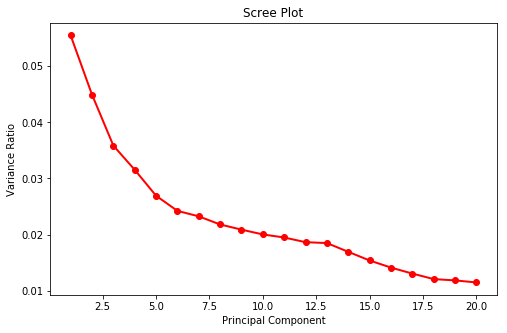

In [4]:
#This section scales the data in order to create a more useable data set
# scale attributes by the training set
stdsclrObj = StandardScaler()

# find scalings for each column that make this zero mean and unit std
#We use the training data to help fit the standard dev
# find scalings for each column that make this zero mean and unit std
stdsclrObj.fit(gameDataPCA) 

# to transform new feature data
# apply to training
gameData_scaled = stdsclrObj.transform(gameDataPCA)

components = 20

pca = PCA(n_components= components)

#Run PCA
# fit data and then transform it
gameData_pca = pca.fit(gameData_scaled).transform(gameData_scaled) 

variance_ratio = pca.explained_variance_ratio_

fig = plt.figure(figsize=(8,5))
#Create 
CompentValues = np.arange(components) + 1
plt.plot(CompentValues, variance_ratio, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.show()

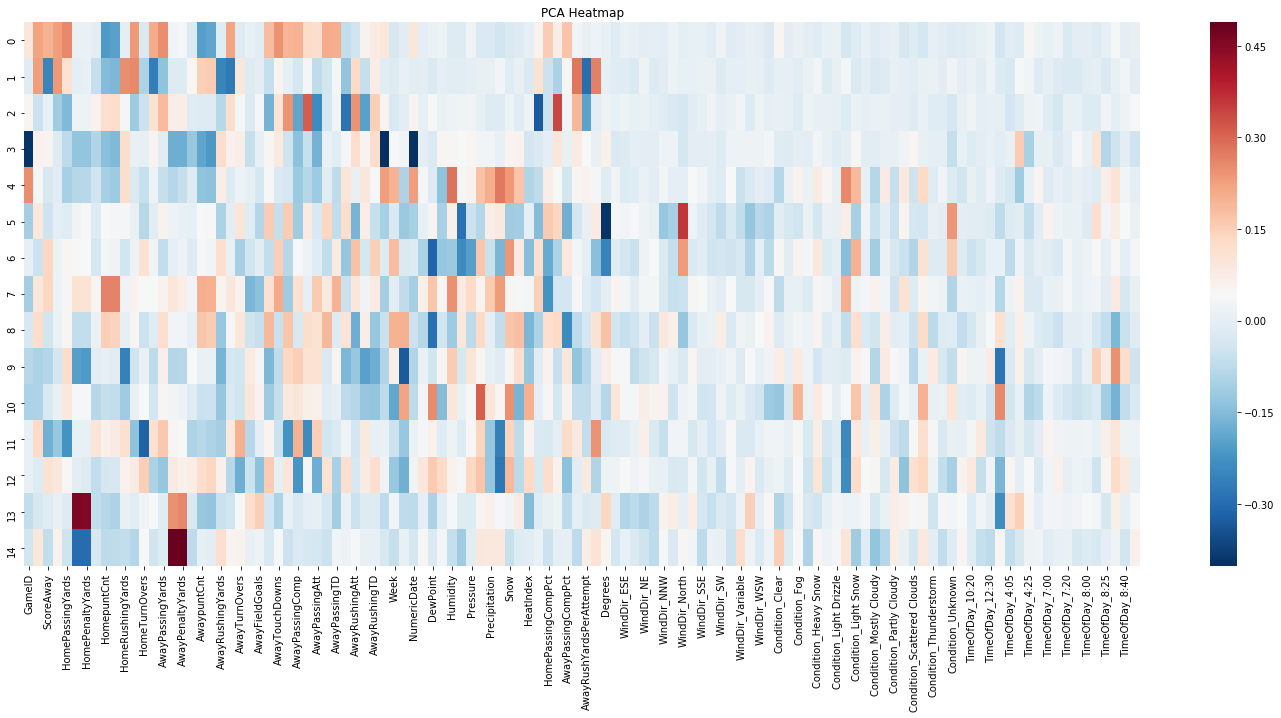

In [5]:
pca_components = pca.components_

compValues = pd.DataFrame(pca_components,columns=gameDataPCA.columns)

#show top 40 vectors due to the analysis 
compValues = compValues[compValues.index < 15]

plt.figure(figsize=(25,10))

plt.title('PCA Heatmap')

sb.heatmap(compValues, cmap = 'RdBu_r', cbar=True)

plt.show()

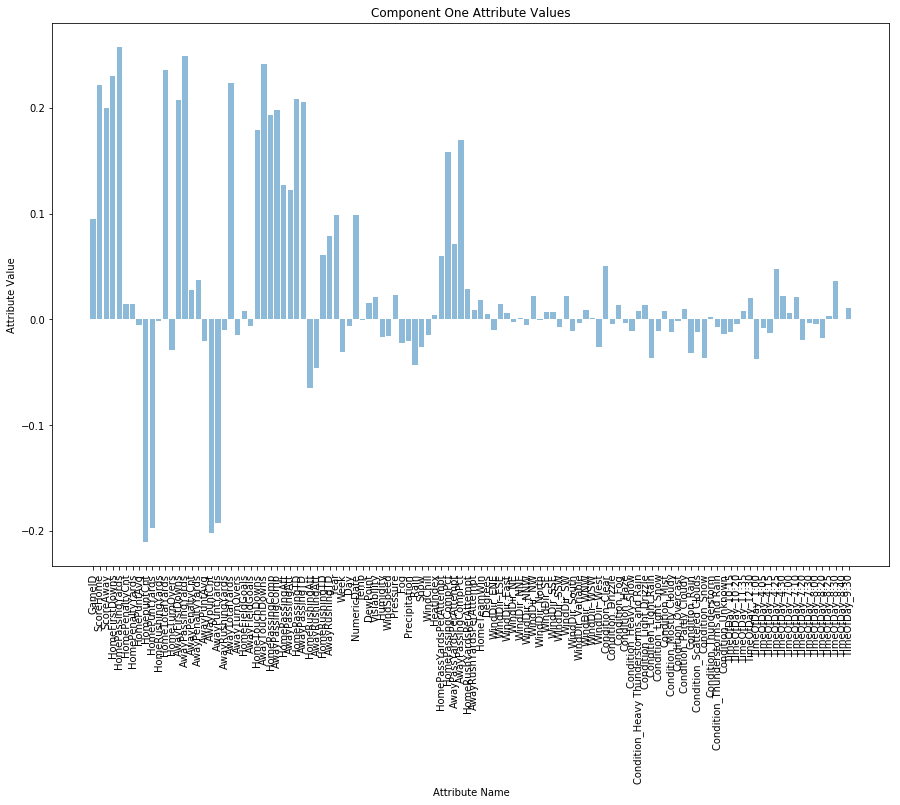

In [6]:
compValuesTransformed = compValues.T

#print (compValuesTransformed[0])

fig = plt.figure(figsize=(15,10))
#Create
objects = compValuesTransformed.index
y_pos = np.arange(len(objects)) + 1
performance = compValuesTransformed[0]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=90)
plt.xlabel('Attribute Name')
plt.ylabel('Attribute Value')
plt.title('Component One Attribute Values')

plt.show()

# Creating Logistic Regression Model
https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [189]:
#Get All PCA Data
dfPCAValues = pd.DataFrame(performance)

#Set Column Names for dataframe created above
dfPCAValues.columns = ['values']

#Get all Columns with an absolute value greater than .05
dfColumnNamesForRegression = dfPCAValues[abs(dfPCAValues['values']) > .05]

#Create new Data frame with Correct Column Names.
dfColumnName = pd.DataFrame(dfColumnNamesForRegression.index, columns = ['ColumnName'])

#Create empty dataFrame for column values
dfColValuesForRegression = pd.DataFrame()

#Fill new dataFrame
for column in dfColumnName.values:
    insertColumn = column[-1]
    if insertColumn not in ('ScoreHome', 'ScoreAway'):
        dfColValuesForRegression[insertColumn] = gameDataPCA[[insertColumn]] 
    
y = gameDataPCA['HomeTeamWin']

X = dfColValuesForRegression


# Create Logistic Regression Model 

In [191]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit

# first we create a reusable logisitic regression object
# get object
lr_clf = LogisticRegression(penalty='l1', C=1.0, class_weight=None) 

# train object
lr_clf.fit(X,y)
    
# get test set precitions
y_hat = lr_clf.predict(X) 

#print('Intercept: ', clf.intercept_, 'Coeffiencts: ', clf.coef_)

#Get Accuracy_Score and Confusion Matrix
acc = mt.accuracy_score(y,y_hat)
conf = mt.confusion_matrix(y,y_hat)
print("====Iteration",iter_num," ====")
print("accuracy", acc )
print("confusion matrix\n",conf)


('====Iteration', 6, ' ====')
('accuracy', 0.70036477331943725)
('confusion matrix\n', array([[506, 328],
       [247, 838]]))


# Cross Validation for the model

In [192]:

#Create CV_Object
cv_object = ShuffleSplit(n_splits=5,
                         test_size  = .3)

iter_num = 1
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
  
    #Create Training DataSet
    X_train = X.loc[X.index.isin(train_indices)]
    y_train = y.loc[y.index.isin(train_indices)] 
    
    #Create Testing DataSet
    X_test = X.loc[X.index.isin(test_indices)]
    y_test = y.loc[y.index.isin(test_indices)]
    
    # train object
    lr_clf.fit(X_train,y_train)
    
    # get test set precitions
    y_hat = lr_clf.predict(X_test) 

    #Get Accuracy_Score and Confusion Matrix
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    

('====Iteration', 1, ' ====')
('accuracy', 0.71701388888888884)
('confusion matrix\n', array([[148,  86],
       [ 77, 265]]))
('====Iteration', 2, ' ====')
('accuracy', 0.68055555555555558)
('confusion matrix\n', array([[141, 105],
       [ 79, 251]]))
('====Iteration', 3, ' ====')
('accuracy', 0.71180555555555558)
('confusion matrix\n', array([[149,  86],
       [ 80, 261]]))
('====Iteration', 4, ' ====')
('accuracy', 0.68055555555555558)
('confusion matrix\n', array([[145, 106],
       [ 78, 247]]))
('====Iteration', 5, ' ====')
('accuracy', 0.69444444444444442)
('confusion matrix\n', array([[151, 117],
       [ 59, 249]]))
